In [1]:
from __future__ import print_function

%reload_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR

print(torch.cuda.get_device_name(0))

Tesla P100-PCIE-16GB


In [0]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(784, 100) 
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(100, 10)  
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x
    

In [0]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.leaky_relu(x, 0.1)
        x = self.conv2(x)
        x = F.leaky_relu(x, 0.1)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.leaky_relu(x, 0.1)
        output = F.log_softmax(x, dim=1)
        return output


In [0]:
mlp = MLP().cuda()
conv = ConvNet().cuda()

# other mlp hyperparams
mlr = 1e-3
mepochs = 5
# conv hyperparams
clr = 0.1
gamma = 0.8
cepochs = 5

In [0]:

batch_size = 128
test_batch_size = 1000
log_interval = 100

kwargs = {'num_workers': 1, 'pin_memory': True} if torch.cuda.is_available() else {}
train_ds = datasets.MNIST('../data', train=True, download=True,
             transform=transforms.Compose([
               transforms.ToTensor(),
               transforms.Normalize((0.1307,), (0.3081,))])
           )
train_loader = torch.utils.data.DataLoader(
  train_ds, batch_size=batch_size, shuffle=True, **kwargs)
test_ds = datasets.MNIST('../data', train=False,
            transform=transforms.Compose([
              transforms.ToTensor(),
              transforms.Normalize((0.1307,), (0.3081,))])
          )
test_loader = torch.utils.data.DataLoader(
  test_ds, batch_size=test_batch_size, shuffle=True, **kwargs)


In [6]:
# train and test MLP

criterion = nn.CrossEntropyLoss()  
optimizer = torch.optim.Adam(mlp.parameters(), lr=mlr)  

mlp_hist = []
mlp.train()
for epoch in range(mepochs):
    for i, (images, labels) in enumerate(train_loader):  
        # Convert torch tensor to Variable
        images = Variable(images.view(-1, 28*28)).cuda()
        labels = Variable(labels).cuda()
        
        # forward + backward + optimize
        optimizer.zero_grad()  # zero gradient buffer
        outputs = mlp(images)
        loss = criterion(outputs, labels)
        mlp_hist.append(loss) # log for plotting
        loss.backward()
        optimizer.step()
        
        if (i+1) % log_interval == 0:
            print ('Epoch [%d/%d], Step [%d/%d], Loss: %.4f' %
                   (epoch+1, mepochs, i+1, len(train_ds)//batch_size, loss))

mlp.eval()
correct = 0
total = 0
with torch.no_grad():
  for images, labels in test_loader:
      images = Variable(images.view(-1, 28*28)).cuda()
      outputs = mlp(images)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted.cpu() == labels).sum()

print('Accuracy of the network on the %d test images: %.2f %%' % (total, 100 * correct / total))


Epoch [1/5], Step [100/468], Loss: 0.3156
Epoch [1/5], Step [200/468], Loss: 0.2321
Epoch [1/5], Step [300/468], Loss: 0.1804
Epoch [1/5], Step [400/468], Loss: 0.2397
Epoch [2/5], Step [100/468], Loss: 0.1544
Epoch [2/5], Step [200/468], Loss: 0.1679
Epoch [2/5], Step [300/468], Loss: 0.1131
Epoch [2/5], Step [400/468], Loss: 0.1875
Epoch [3/5], Step [100/468], Loss: 0.0984
Epoch [3/5], Step [200/468], Loss: 0.1072
Epoch [3/5], Step [300/468], Loss: 0.0828
Epoch [3/5], Step [400/468], Loss: 0.0662
Epoch [4/5], Step [100/468], Loss: 0.1783
Epoch [4/5], Step [200/468], Loss: 0.0629
Epoch [4/5], Step [300/468], Loss: 0.2385
Epoch [4/5], Step [400/468], Loss: 0.0460
Epoch [5/5], Step [100/468], Loss: 0.0525
Epoch [5/5], Step [200/468], Loss: 0.1394
Epoch [5/5], Step [300/468], Loss: 0.0989
Epoch [5/5], Step [400/468], Loss: 0.0304
Accuracy of the network on the 10000 test images: 97.00 %


In [31]:
# train and test ConvNet

criterion = nn.CrossEntropyLoss()  
optimizer = torch.optim.Adadelta(conv.parameters(), lr=clr)  
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

conv_hist = []
conv.train()
for epoch in range(cepochs):
    for i, (images, labels) in enumerate(train_loader):  
        images = images.cuda()
        labels = labels.cuda()
        # forward + backward + optimize
        optimizer.zero_grad()  # zero gradient buffer
        outputs = conv(images)
        loss = criterion(outputs, labels)
        conv_hist.append(loss) # log for plotting
        loss.backward()
        optimizer.step()
        
        if (i+1) % log_interval == 0:
            print ('Epoch [%d/%d], Step [%d/%d], Loss: %.4f' %
                   (epoch+1, cepochs, i+1, len(train_ds)//batch_size, loss))
    scheduler.step()

conv.eval()
correct = 0
total = 0
with torch.no_grad():
  for images, labels in test_loader:
      images = images.cuda()
      outputs = conv(images)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted.cpu() == labels).sum()

print('Accuracy of the network on the %d test images: %.2f %%' % (total, 100 * correct / total))

Epoch [1/5], Step [100/468], Loss: 0.0956
Epoch [1/5], Step [200/468], Loss: 0.0130
Epoch [1/5], Step [300/468], Loss: 0.0510
Epoch [1/5], Step [400/468], Loss: 0.0396
Epoch [2/5], Step [100/468], Loss: 0.0454
Epoch [2/5], Step [200/468], Loss: 0.0294
Epoch [2/5], Step [300/468], Loss: 0.0105
Epoch [2/5], Step [400/468], Loss: 0.0526
Epoch [3/5], Step [100/468], Loss: 0.0099
Epoch [3/5], Step [200/468], Loss: 0.0822
Epoch [3/5], Step [300/468], Loss: 0.0370
Epoch [3/5], Step [400/468], Loss: 0.0911
Epoch [4/5], Step [100/468], Loss: 0.0282
Epoch [4/5], Step [200/468], Loss: 0.0354
Epoch [4/5], Step [300/468], Loss: 0.0097
Epoch [4/5], Step [400/468], Loss: 0.0120
Epoch [5/5], Step [100/468], Loss: 0.0170
Epoch [5/5], Step [200/468], Loss: 0.0303
Epoch [5/5], Step [300/468], Loss: 0.0363
Epoch [5/5], Step [400/468], Loss: 0.0457
Accuracy of the network on the 10000 test images: 98.00 %


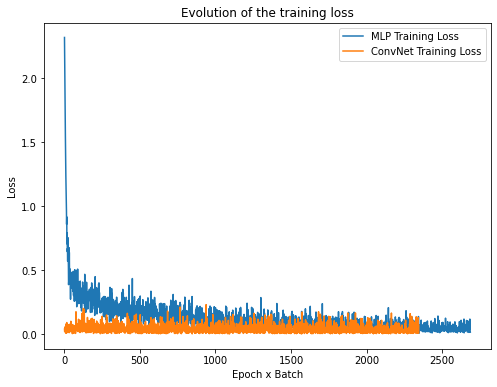

In [32]:

mx = np.arange(1, len(mlp_hist) + 1)
cx = np.arange(1, len(conv_hist) + 1)

plt.figure(figsize=(8, 6))
plt.plot(mx, mlp_hist, label="MLP Training Loss")
plt.plot(cx, conv_hist, label="ConvNet Training Loss")
plt.xlabel('Epoch x Batch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.title("Evolution of the training loss")
plt.show()
